In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions download -c quora-question-pairs


quora-question-pairs.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
with zipfile.ZipFile('quora-question-pairs.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/quora_question_pairs')


In [ ]:
import zipfile

# Unzip train.csv.zip
with zipfile.ZipFile('/content/quora_question_pairs/train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/quora_question_pairs')


## Data Preprocessing, Feature Engineering and Model Training with Random Forest and XGBoost



In [ ]:
# 1. Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [ ]:

# Suppressing warnings for cleaner output
warnings.filterwarnings('ignore')

In [ ]:

# 2. Loading the Dataset
# Reading the dataset into a pandas DataFrame
df = pd.read_csv("/content/quora_question_pairs/train.csv")
print("Dataset Shape:", df.shape)

Dataset Shape: (404290, 6)


In [ ]:

# 3. Displaying the First Few Rows
# Displaying the first few rows of the dataset
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
# 4. Sampling the Dataset
# Sampling 30,000 random rows for analysis
new_df = df.sample(30000, random_state=2)


In [ ]:
# 5. Checking for Missing Values
# Checking for missing values in the sampled dataset
print("Missing values in new_df:\n", new_df.isnull().sum())
new_df.head()

Missing values in new_df:
 id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0


In [ ]:
# 6. Checking for Duplicate Rows
# Counting duplicate rows in the sampled dataset
print("Duplicate Rows in new_df:", new_df.duplicated().sum())


Duplicate Rows in new_df: 0


In [ ]:
# 7. Distribution of Duplicate and Non-Duplicate Questions
print("Duplicate Question Counts:\n", new_df['is_duplicate'].value_counts())
print("Percentage Distribution of Duplicates:\n", (new_df['is_duplicate'].value_counts() / new_df['is_duplicate'].count()) * 100)


Duplicate Question Counts:
 is_duplicate
0    19013
1    10987
Name: count, dtype: int64
Percentage Distribution of Duplicates:
 is_duplicate
0    63.376667
1    36.623333
Name: count, dtype: float64


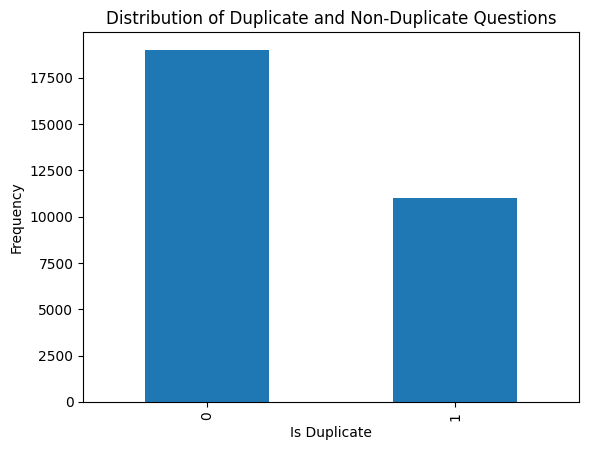

In [ ]:
# Bar plot to show the frequency of duplicate and non-duplicate pairs
new_df['is_duplicate'].value_counts().plot(kind='bar')
plt.title('Distribution of Duplicate and Non-Duplicate Questions')
plt.xlabel('Is Duplicate')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# 8. Analyzing Unique and Repeated Questions
# Concatenating qid1 and qid2 columns to calculate unique and repeated questions
qid = pd.Series(new_df['qid1'].tolist() + new_df['qid2'].tolist())
print('Number of Unique Questions:', np.unique(qid).shape[0])
x = qid.value_counts() > 1
print('Number of Questions Getting Repeated:', x[x].shape[0])

Number of Unique Questions: 55299
Number of Questions Getting Repeated: 3480


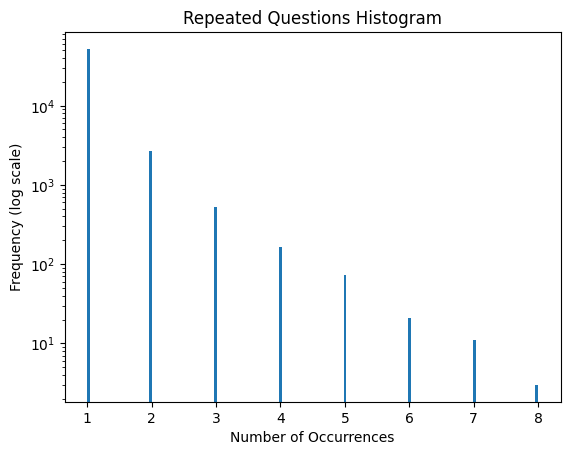

In [ ]:
# 9. Repeated Questions Histogram
# Histogram showing the frequency distribution of repeated questions
plt.hist(qid.value_counts().values, bins=160)
plt.yscale('log')  # Log scale for better visibility
plt.title('Repeated Questions Histogram')
plt.xlabel('Number of Occurrences')
plt.ylabel('Frequency (log scale)')
plt.show()

In [ ]:
# 10. Feature Engineering
# Creating new features based on question length and word counts
new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,76,77
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0,49,57
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0,105,120
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0,59,146
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0,35,50


In [ ]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))

new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,76,77,12,12
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0,49,57,12,15
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0,105,120,25,17
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0,59,146,12,30
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0,35,50,5,9


In [ ]:
# Function to calculate common words between two questions
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)

In [ ]:
new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,76,77,12,12,11
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0,49,57,12,15,7
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0,105,120,25,17,2
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0,59,146,12,30,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0,35,50,5,9,3


In [ ]:
# Function to calculate total unique words in both questions
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return (len(w1) + len(w2))

In [ ]:
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,76,77,12,12,11,24
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0,49,57,12,15,7,23
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0,105,120,25,17,2,34
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0,59,146,12,30,0,32
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0,35,50,5,9,3,13


In [ ]:
# Calculating the share of common words
new_df['word_share'] = round(new_df['word_common'] / new_df['word_total'], 2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1,76,77,12,12,11,24,0.46
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0,49,57,12,15,7,23,0.30
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0,105,120,25,17,2,34,0.06
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0,59,146,12,30,0,32,0.00
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0,35,50,5,9,3,13,0.23


Minimum characters in question 1: 2
Maximum characters in question 1: 391
Average number of characters in question 1: 59


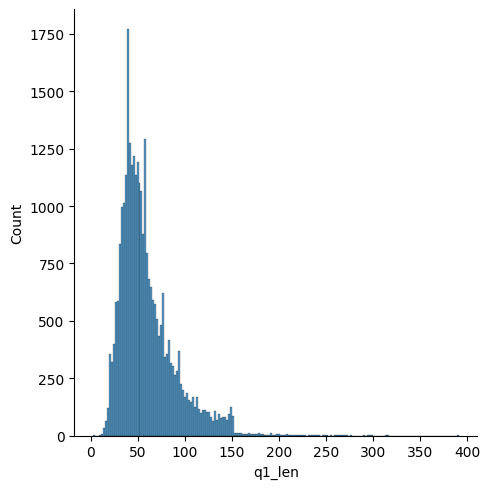

In [ ]:
# 11. Analysis of Features
# Analyzing the length of question 1
sns.displot(new_df['q1_len'])
print('Minimum characters in question 1:', new_df['q1_len'].min())
print('Maximum characters in question 1:', new_df['q1_len'].max())
print('Average number of characters in question 1:', int(new_df['q1_len'].mean()))

Minimum characters in question 2: 6
Maximum characters in question 2: 1151
Average number of characters in question 2: 60


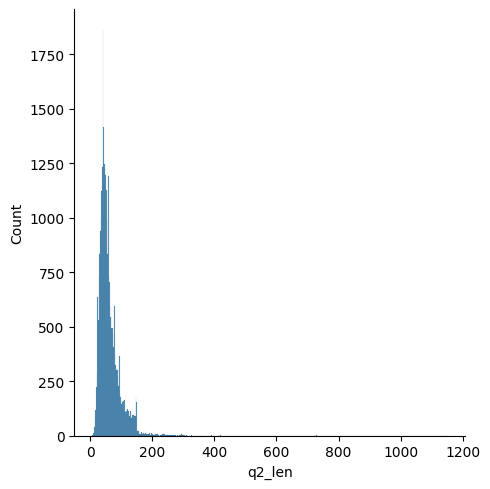

In [ ]:
# Analyzing the length of question 2
sns.displot(new_df['q2_len'])
print('Minimum characters in question 2:', new_df['q2_len'].min())
print('Maximum characters in question 2:', new_df['q2_len'].max())
print('Average number of characters in question 2:', int(new_df['q2_len'].mean()))

Minimum words in question 1: 1
Maximum words in question 1: 72
Average number of words in question 1: 10


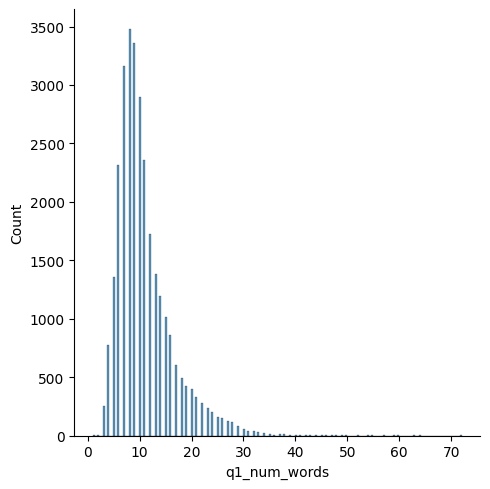

In [ ]:
# Analyzing the number of words in question 1
sns.displot(new_df['q1_num_words'])
print('Minimum words in question 1:', new_df['q1_num_words'].min())
print('Maximum words in question 1:', new_df['q1_num_words'].max())
print('Average number of words in question 1:', int(new_df['q1_num_words'].mean()))

Minimum words in question 2: 1
Maximum words in question 2: 237
Average number of words in question 2: 11


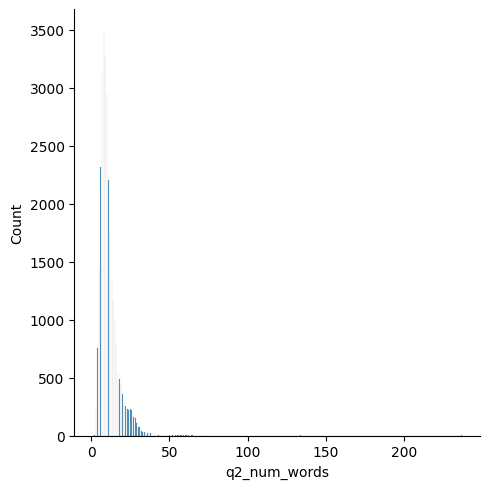

In [ ]:
# Analyzing the number of words in question 2
sns.displot(new_df['q2_num_words'])
print('Minimum words in question 2:', new_df['q2_num_words'].min())
print('Maximum words in question 2:', new_df['q2_num_words'].max())
print('Average number of words in question 2:', int(new_df['q2_num_words'].mean()))

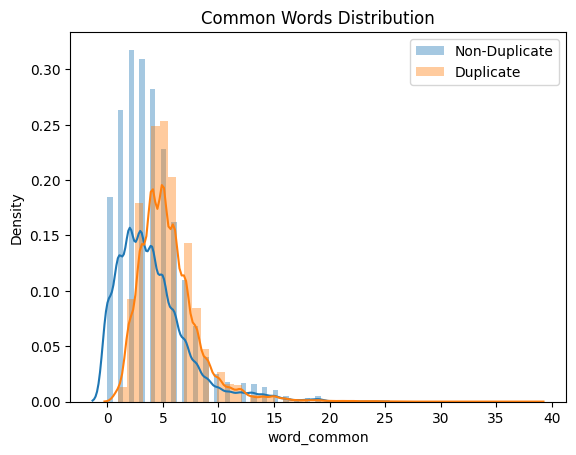

In [ ]:
# 12. Analyzing Common Words
# Distribution of common words for duplicate and non-duplicate questions
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_common'], label='Non-Duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_common'], label='Duplicate')
plt.legend()
plt.title('Common Words Distribution')
plt.show()

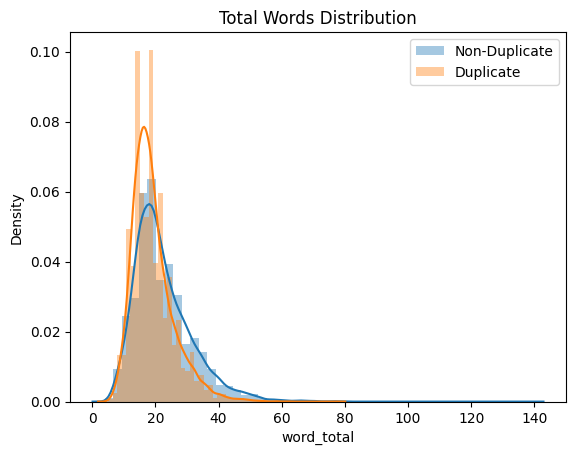

In [ ]:
# 13. Analyzing Total Words
# Distribution of total words for duplicate and non-duplicate questions
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_total'], label='Non-Duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_total'], label='Duplicate')
plt.legend()
plt.title('Total Words Distribution')
plt.show()

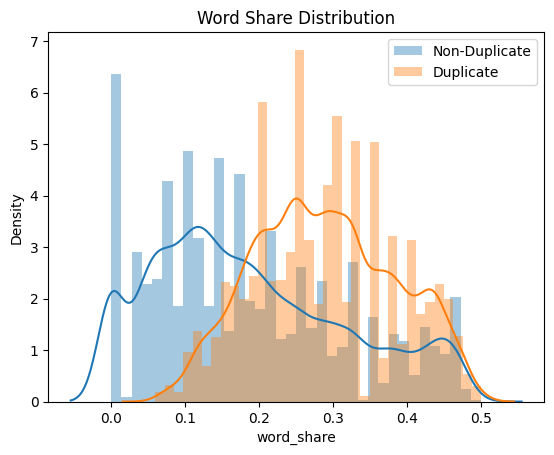

In [ ]:
# 14. Analyzing Word Share
# Distribution of word share for duplicate and non-duplicate questions
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_share'], label='Non-Duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_share'], label='Duplicate')
plt.legend()
plt.title('Word Share Distribution')
plt.show()

In [ ]:
# 15. Preparing Final DataFrame
# Creating a DataFrame with only question columns
ques_df = new_df[['question1', 'question2']]
ques_df.head()

,question1,question2
398782,What is the best marketing automation tool for...,What is the best marketing automation tool for...
115086,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...
327711,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...
367788,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...
151235,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...


In [ ]:
# Dropping unnecessary columns from the new_df
final_df = new_df.drop(columns=['id', 'qid1', 'qid2', 'question1', 'question2'])
print("Final DataFrame Shape:", final_df.shape)
final_df.head()

Final DataFrame Shape: (30000, 8)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,1,76,77,12,12,11,24,0.46
115086,0,49,57,12,15,7,23,0.30
327711,0,105,120,25,17,2,34,0.06
367788,0,59,146,12,30,0,32,0.00
151235,0,35,50,5,9,3,13,0.23


In [ ]:
# 16. Vectorizing Text Data
from sklearn.feature_extraction.text import CountVectorizer

# Merging the text data from both questions for vectorization
questions = list(ques_df['question1']) + list(ques_df['question2'])

# Vectorizing text data with CountVectorizer
cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(), 2)
temp_df1 = pd.DataFrame(q1_arr, index=ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index=ques_df.index)


In [ ]:

# Concatenating the vectorized data with the final DataFrame
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
print("Shape of Vectorized Data:", temp_df.shape)

Shape of Vectorized Data: (30000, 6000)


In [ ]:
final_df = pd.concat([final_df, temp_df], axis=1)
print("Final DataFrame Shape after Vectorization:", final_df.shape)
final_df.head()

Final DataFrame Shape after Vectorization: (30000, 6008)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,0,1,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
398782,1,76,77,12,12,11,24,0.46,0,0,...,0,0,0,0,0,0,0,0,0,0
115086,0,49,57,12,15,7,23,0.30,0,0,...,0,0,0,0,0,0,0,0,0,0
327711,0,105,120,25,17,2,34,0.06,0,0,...,0,0,0,0,0,0,0,0,0,0
367788,0,59,146,12,30,0,32,0.00,0,0,...,0,0,0,1,0,0,0,0,0,0
151235,0,35,50,5,9,3,13,0.23,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 17. Splitting the Dataset into Train and Test Sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final_df.iloc[:, 1:].values, final_df.iloc[:, 0].values, test_size=0.2, random_state=1)


In [ ]:
# 18. Training a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Making predictions on the test set
y_pred = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred)
print("Random Forest Classifier Accuracy:", accuracy_rf)

Random Forest Classifier Accuracy: 0.7696666666666667


In [ ]:
# 19. Training an XGBoost Classifier
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# Making predictions on the test set
y_pred_xgb = xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Classifier Accuracy:", accuracy_xgb)

XGBoost Classifier Accuracy: 0.7661666666666667
